# 导入需要的库

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from scipy.io import loadmat, savemat
from torch.utils.data import DataLoader
import numpy as np
import scipy.spatial
import torchvision
import time
import copy

# 构建图像、文本子网络

In [2]:
class ImageNN(nn.Module):                                              
    def __init__(self, input_dim=4096, output_dim=1024):
        super(ImageNN, self).__init__()
        self.denseL1 = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        out = F.relu(self.denseL1(x))
        return out


class TextNN(nn.Module):                                             
    def __init__(self, input_dim=300, output_dim=1024):
        super(TextNN, self).__init__()
        self.denseL1 = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = F.relu(self.denseL1(x))
        return out


class IDCM_NN(nn.Module):                                                    
    def __init__(self, img_input_dim=4096, img_output_dim=2048,
                 text_input_dim=1024, text_output_dim=2048, minus_one_dim=1024, output_dim=20):
        super(IDCM_NN, self).__init__()
        self.img_net = ImageNN(img_input_dim, img_output_dim)
        self.text_net = TextNN(text_input_dim, text_output_dim)
        self.linearLayer = nn.Linear(img_output_dim, minus_one_dim)
        self.linearLayer1 = nn.Linear(text_output_dim, minus_one_dim)
        self.linearLayer2 = nn.Linear(minus_one_dim, output_dim)


    def forward(self, img, text):
        view1_feature = self.img_net(img)    
        view2_feature = self.text_net(text)  
        view1_feature = self.linearLayer(view1_feature)
        view2_feature = self.linearLayer1(view2_feature)

        view1_predict = self.linearLayer2(view1_feature)      
        view2_predict = self.linearLayer2(view2_feature)
        return view1_feature, view2_feature, view1_predict, view2_predict


# 加载数据集

In [4]:
class CustomDataSet(Dataset):
    def __init__(
            self,
            images,
            texts,
            labels):
        self.images = images
        self.texts = texts
        self.labels = labels

    def __getitem__(self, index):
        img = self.images[index]                                
        text = self.texts[index]
        label = self.labels[index]
        return img, text, label

    def __len__(self):
        count = len(self.images)
        assert len(                                        
            self.images) == len(self.labels)
        return count


def ind2vec(ind, N=None):
    ind = np.asarray(ind)                                 
    if N is None:
        N = ind.max() + 1
    return np.arange(N) == np.repeat(ind, N, axis=1)

def get_loader(path, batch_size):
    img_train = loadmat(path+"train_img.mat")['train_img']
    img_test = loadmat(path + "test_img.mat")['test_img']
    text_train = loadmat(path+"train_txt.mat")['train_txt']
    text_test = loadmat(path + "test_txt.mat")['test_txt']
    label_train = loadmat(path+"train_img_lab.mat")['train_img_lab']
    label_test = loadmat(path + "test_img_lab.mat")['test_img_lab']


    label_train = ind2vec(label_train).astype(int)
    label_test = ind2vec(label_test).astype(int)


    imgs = {'train': img_train, 'test': img_test}
    texts = {'train': text_train, 'test': text_test}
    labels = {'train': label_train, 'test': label_test}
    dataset = {x: CustomDataSet(images=imgs[x], texts=texts[x], labels=labels[x])
               for x in ['train', 'test']}

    shuffle = {'train': False, 'test': False}

    dataloader = {x: DataLoader(dataset[x], batch_size=batch_size,
                                shuffle=shuffle[x], num_workers=0) for x in ['train', 'test']}

   
    img_dim = img_train.shape[1]
    text_dim = text_train.shape[1]
    num_class = label_train.shape[1]


    input_data_par = {}
    input_data_par['img_test'] = img_test
    input_data_par['text_test'] = text_test
    input_data_par['label_test'] = label_test
    input_data_par['img_train'] = img_train
    input_data_par['text_train'] = text_train
    input_data_par['label_train'] = label_train
    input_data_par['img_dim'] = img_dim
    input_data_par['text_dim'] = text_dim
    input_data_par['num_class'] = num_class

    return dataloader, input_data_par

# 计算map

In [5]:
def fx_calc_map_label(image, text, label, k=0, dist_method='COS'):
    if dist_method == 'L2':
        dist = scipy.spatial.distance.cdist(image, text, 'euclidean')
    elif dist_method == 'COS':
        dist = scipy.spatial.distance.cdist(image, text, 'cosine')
    ord = dist.argsort()
    numcases = dist.shape[0]
    if k == 0:
        k = numcases
    res = []
    for i in range(numcases):
        order = ord[i]
        p = 0.0
        r = 0.0
        for j in range(k):
            if label[i] == label[order[j]]:
                r += 1
                p += (r / (j + 1))
        if r > 0:
            res += [p / r]
        else:
            res += [0]
    return np.mean(res)

# 损失函数构建

构建三元组损失
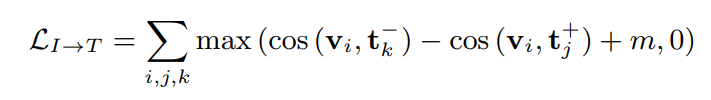

In [65]:
#余弦距离
def cos_distance(source, target):
    cos_sim = F.cosine_similarity(source.unsqueeze(1), target, dim=-1)
    distances = torch.clamp(1 - cos_sim, 0)
    return distances

class TripletLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(TripletLoss, self).__init__()
        self.reduction = reduction

    def forward(self, source, s_labels, target=None, t_labels=None, margin=0):
        if target is None:
            target = source
        if t_labels is None:
            t_labels = s_labels

        pairwise_dist = cos_distance(source, target)
#锚点与正样本的距离a
        anchor_positive_dist = pairwise_dist.unsqueeze(2)
#锚点与负样本的距离b
        anchor_negative_dist = pairwise_dist.unsqueeze(1)
#a-b+边距
        triplet_loss = anchor_positive_dist - anchor_negative_dist + margin
#将小于0的值修改为0
        triplet_loss = triplet_loss.clamp(0)

        valid_triplets = triplet_loss.gt(1e-16).float()
        num_positive_triplets = valid_triplets.sum()

        if self.reduction == 'mean':
            triplet_loss = triplet_loss.sum() / (num_positive_triplets + 1e-16)
        elif self.reduction == 'sum':
            triplet_loss = triplet_loss.sum()

        return triplet_loss

总损失函数

In [66]:
def calc_loss(view1_feature, view2_feature, view1_predict, view2_predict, labels_1, labels_2, alpha, beta,gamma):

    tri_loss = TripletLoss(reduction='mean')
    tri_i2t = tri_loss(view1_feature, labels_1.float(), target=view2_feature, margin=0.1)
    tri_t2i = tri_loss(view2_feature, labels_2.float(), target=view1_feature, margin=0.1)
    cos_tri = tri_i2t + tri_t2i
 
    floss = ((view1_feature - view2_feature)**2).sum(1).sqrt().mean()
    lloss = ((view1_predict-labels_1.float())**2).sum(1).sqrt().mean() + ((view2_predict-labels_2.float())**2).sum(1).sqrt().mean()

    im_loss = alpha * cos_tri + beta*floss+ gamma*lloss

    return im_loss

# 训练部分

In [67]:

def train_model(model, data_loaders, optimizer, alpha, beta,gamma, num_epochs):
    since = time.time()
    test_img_acc_history = []
    test_txt_acc_history = []
    epoch_loss_history =[]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects_img = 0
            running_corrects_txt = 0
            for imgs, txts, labels in data_loaders[phase]:
                if torch.sum(imgs != imgs)>1 or torch.sum(txts != txts)>1:
                    print("Data contains Nan.")
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                  
                    if torch.cuda.is_available():
                        imgs = imgs.cuda()
                        txts = txts.cuda()
                        labels = labels.cuda()

                    optimizer.zero_grad()

                    view1_feature, view2_feature, view1_predict, view2_predict = model(imgs, txts)

                    loss = calc_loss(view1_feature, view2_feature, view1_predict,
                                     view2_predict, labels, labels, alpha, beta,gamma)

                    img_preds = view1_predict
                    txt_preds = view2_predict

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                running_corrects_img += torch.sum(torch.argmax(img_preds, dim=1) == torch.argmax(labels, dim=1))
                running_corrects_txt += torch.sum(torch.argmax(txt_preds, dim=1) == torch.argmax(labels, dim=1))

            epoch_loss = running_loss / len(data_loaders[phase].dataset)
            t_imgs, t_txts, t_labels = [], [], []
            with torch.no_grad():
                for imgs, txts, labels in data_loaders['test']:
                    if torch.cuda.is_available():
                            imgs = imgs.cuda()
                            txts = txts.cuda()
                            labels = labels.cuda()
                    t_view1_feature, t_view2_feature, _, _ = model(imgs, txts)
                    t_imgs.append(t_view1_feature.cpu().numpy())
                    t_txts.append(t_view2_feature.cpu().numpy())
                    t_labels.append(labels.cpu().numpy())
            t_imgs = np.concatenate(t_imgs)
            t_txts = np.concatenate(t_txts)
            t_labels = np.concatenate(t_labels).argmax(1)
            img2text = fx_calc_map_label(t_imgs, t_txts, t_labels)
            txt2img = fx_calc_map_label(t_txts, t_imgs, t_labels)

            print('{} Loss: {:.4f} Img2Txt: {:.4f}  Txt2Img: {:.4f}'.format(phase, epoch_loss, img2text, txt2img))

            if phase == 'test' and (img2text + txt2img) / 2. > best_acc:
                best_acc = (img2text + txt2img) / 2.
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'test':
                test_img_acc_history.append(img2text)
                test_txt_acc_history.append(txt2img)
                epoch_loss_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best average ACC: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, test_img_acc_history, test_txt_acc_history, epoch_loss_history

# 主函数+参数设置

In [68]:
if __name__ == '__main__':
    dataset = 'pascal'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    DATA_DIR = 'data/' + dataset + '/'
    MAX_EPOCH = 130
    alpha = 1e-3
    beta = 1
    gamma=10
    weight_decay = 0
    batch_size = 100
    lr = 1e-4
    betas = (0.5, 0.999)
    print('加载数据')

    data_loader, input_data_par = get_loader(DATA_DIR, batch_size)

    model_ft = IDCM_NN(img_input_dim=input_data_par['img_dim'], text_input_dim=input_data_par['text_dim'], output_dim=input_data_par['num_class']).to(device)
    params_to_update = list(model_ft.parameters())
    optimizer = optim.Adam(params_to_update, lr=lr, betas=betas,weight_decay=weight_decay)
    print('开始训练')
    model_ft, img_acc_hist, txt_acc_hist, loss_hist = train_model(model_ft, data_loader, optimizer, alpha, beta,gamma,MAX_EPOCH)
    print('训练完成')
    print('在测试集评估')
    view1_feature, view2_feature, view1_predict, view2_predict = model_ft(torch.tensor(input_data_par['img_test']).to(device), torch.tensor(input_data_par['text_test']).to(device))
    label = torch.argmax(torch.tensor(input_data_par['label_test']), dim=1)
    view1_feature = view1_feature.detach().cpu().numpy()
    view2_feature = view2_feature.detach().cpu().numpy()
    view1_predict = view1_predict.detach().cpu().numpy()
    view2_predict = view2_predict.detach().cpu().numpy()
    img_to_txt = fx_calc_map_label(view1_feature, view2_feature, label)
    print('...Image to Text MAP = {}'.format(img_to_txt))

    txt_to_img = fx_calc_map_label(view2_feature, view1_feature, label)
    print('...Text to Image MAP = {}'.format(txt_to_img))

    print('...Average MAP = {}'.format(((img_to_txt + txt_to_img) / 2.)))

加载数据
开始训练
Epoch 1/130
--------------------
train Loss: 0.2704 Img2Txt: 0.2171  Txt2Img: 0.2132
test Loss: 0.2217 Img2Txt: 0.2171  Txt2Img: 0.2132
Epoch 2/130
--------------------
train Loss: 0.2229 Img2Txt: 0.4099  Txt2Img: 0.4798
test Loss: 0.1951 Img2Txt: 0.4099  Txt2Img: 0.4798
Epoch 3/130
--------------------
train Loss: 0.1990 Img2Txt: 0.5426  Txt2Img: 0.5804
test Loss: 0.1780 Img2Txt: 0.5426  Txt2Img: 0.5804
Epoch 4/130
--------------------
train Loss: 0.1784 Img2Txt: 0.5932  Txt2Img: 0.6240
test Loss: 0.1654 Img2Txt: 0.5932  Txt2Img: 0.6240
Epoch 5/130
--------------------
train Loss: 0.1610 Img2Txt: 0.6113  Txt2Img: 0.6585
test Loss: 0.1577 Img2Txt: 0.6113  Txt2Img: 0.6585
Epoch 6/130
--------------------
train Loss: 0.1489 Img2Txt: 0.6362  Txt2Img: 0.6808
test Loss: 0.1550 Img2Txt: 0.6362  Txt2Img: 0.6808
Epoch 7/130
--------------------
train Loss: 0.1426 Img2Txt: 0.6357  Txt2Img: 0.6748
test Loss: 0.1537 Img2Txt: 0.6357  Txt2Img: 0.6748
Epoch 8/130
--------------------
train

train Loss: 0.0745 Img2Txt: 0.6591  Txt2Img: 0.6992
test Loss: 0.1332 Img2Txt: 0.6591  Txt2Img: 0.6992
Epoch 62/130
--------------------
train Loss: 0.0698 Img2Txt: 0.6371  Txt2Img: 0.6823
test Loss: 0.1281 Img2Txt: 0.6371  Txt2Img: 0.6823
Epoch 63/130
--------------------
train Loss: 0.0705 Img2Txt: 0.6439  Txt2Img: 0.6847
test Loss: 0.1325 Img2Txt: 0.6439  Txt2Img: 0.6847
Epoch 64/130
--------------------
train Loss: 0.0712 Img2Txt: 0.6630  Txt2Img: 0.7018
test Loss: 0.1296 Img2Txt: 0.6630  Txt2Img: 0.7018
Epoch 65/130
--------------------
train Loss: 0.0724 Img2Txt: 0.6563  Txt2Img: 0.6909
test Loss: 0.1301 Img2Txt: 0.6563  Txt2Img: 0.6909
Epoch 66/130
--------------------
train Loss: 0.0666 Img2Txt: 0.6883  Txt2Img: 0.6933
test Loss: 0.1265 Img2Txt: 0.6883  Txt2Img: 0.6933
Epoch 67/130
--------------------
train Loss: 0.0644 Img2Txt: 0.6575  Txt2Img: 0.6991
test Loss: 0.1313 Img2Txt: 0.6575  Txt2Img: 0.6991
Epoch 68/130
--------------------
train Loss: 0.0697 Img2Txt: 0.6676  Txt2I

train Loss: 0.0567 Img2Txt: 0.6550  Txt2Img: 0.6865
test Loss: 0.1265 Img2Txt: 0.6550  Txt2Img: 0.6865
Epoch 122/130
--------------------
train Loss: 0.0567 Img2Txt: 0.6364  Txt2Img: 0.6852
test Loss: 0.1264 Img2Txt: 0.6364  Txt2Img: 0.6852
Epoch 123/130
--------------------
train Loss: 0.0555 Img2Txt: 0.6535  Txt2Img: 0.6888
test Loss: 0.1254 Img2Txt: 0.6535  Txt2Img: 0.6888
Epoch 124/130
--------------------
train Loss: 0.0548 Img2Txt: 0.6535  Txt2Img: 0.6922
test Loss: 0.1257 Img2Txt: 0.6535  Txt2Img: 0.6922
Epoch 125/130
--------------------
train Loss: 0.0554 Img2Txt: 0.6636  Txt2Img: 0.6888
test Loss: 0.1250 Img2Txt: 0.6636  Txt2Img: 0.6888
Epoch 126/130
--------------------
train Loss: 0.0531 Img2Txt: 0.6429  Txt2Img: 0.6794
test Loss: 0.1263 Img2Txt: 0.6429  Txt2Img: 0.6794
Epoch 127/130
--------------------
train Loss: 0.0565 Img2Txt: 0.6624  Txt2Img: 0.6901
test Loss: 0.1250 Img2Txt: 0.6624  Txt2Img: 0.6901
Epoch 128/130
--------------------
train Loss: 0.0502 Img2Txt: 0.6387